## GradCAM

### ライブラリ

In [143]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
from torchvision.transforms.functional import to_pil_image
%load_ext autoreload
%autoreload 2
import utils

torch.manual_seed(42)  # 乱数のシードを固定

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Input Data

In [155]:
# ロードする重みファイルのパス
weight_path = fr'/Users/hisashi/Desktop/git-hub/deep-learning/sample.pth'

# 画像のパス
image_path = "/Users/hisashi/Desktop/git-hub/deep-learning/hymenoptera_data/train/ants/150801171_cd86f17ed8.jpg"

### GradCAM

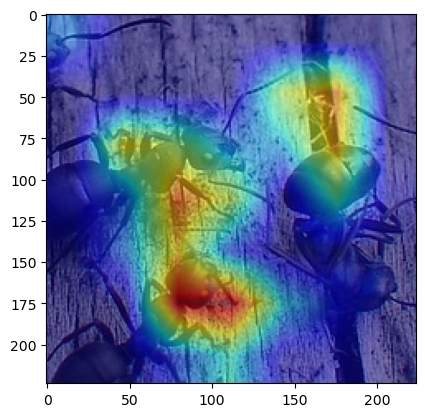

In [148]:
# 1. モデルをロード

model = models.efficientnet_v2_s()
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)
checkpoint  = torch.load(weight_path)
model.load_state_dict(checkpoint['model_state_dict'])

# 2. Grad-CAM の対象レイヤーを指定
target_layer = model.features[-1]  # 最後の特徴層を指定

# 3. Grad-CAM の設定
cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)

# 4. 画像の前処理
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_pil = Image.open(image_path).convert("RGB")
input_tensor = transform(image_pil).unsqueeze(0)  # バッチ次元を追加

# 5. モデルに画像を通す
outputs = model(input_tensor)

# 6. 予測クラスを取得
pred_class = outputs.argmax(dim=1).item()

# 7. Grad-CAM を適用
activation_map = cam_extractor(pred_class, outputs)

# 8. activation_map を作成
activation_map = activation_map[0].detach().cpu().numpy()           # (1, 7, 7)
activation_map = np.transpose(activation_map, (1, 2, 0))            # (1, 7, 7) -> (7, 7, 1)
activation_map = cv2.resize(activation_map, (224, 224))             # (7, 7, 1) -> (224, 224, 1)
activation_map = utils.toHeatmap(activation_map)

# 9. 元画像を処理
image_cv2 = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
image_cv2 = image_cv2 / 255.0
image_cv2 = image_cv2[image_cv2.shape[0]//2-112:image_cv2.shape[0]//2+112, image_cv2.shape[1]//2-112:image_cv2.shape[1]//2+112, :]

# 10. 画像と activation_map をオーバーレイ
alpha = 0.5
image_ovelay = image_cv2 * alpha + activation_map * (1 - alpha)
plt.imshow(image_ovelay)
# plt.axis("off")
plt.show()

In [164]:
image_folder = fr"/Users/hisashi/Desktop/git-hub/deep-learning/test_data"
image_files = [f for f in os.listdir(image_folder) if f.endswith(('jpg', 'png', 'jpeg'))]
class_dict = {0: 'ants', 1: 'bees'}

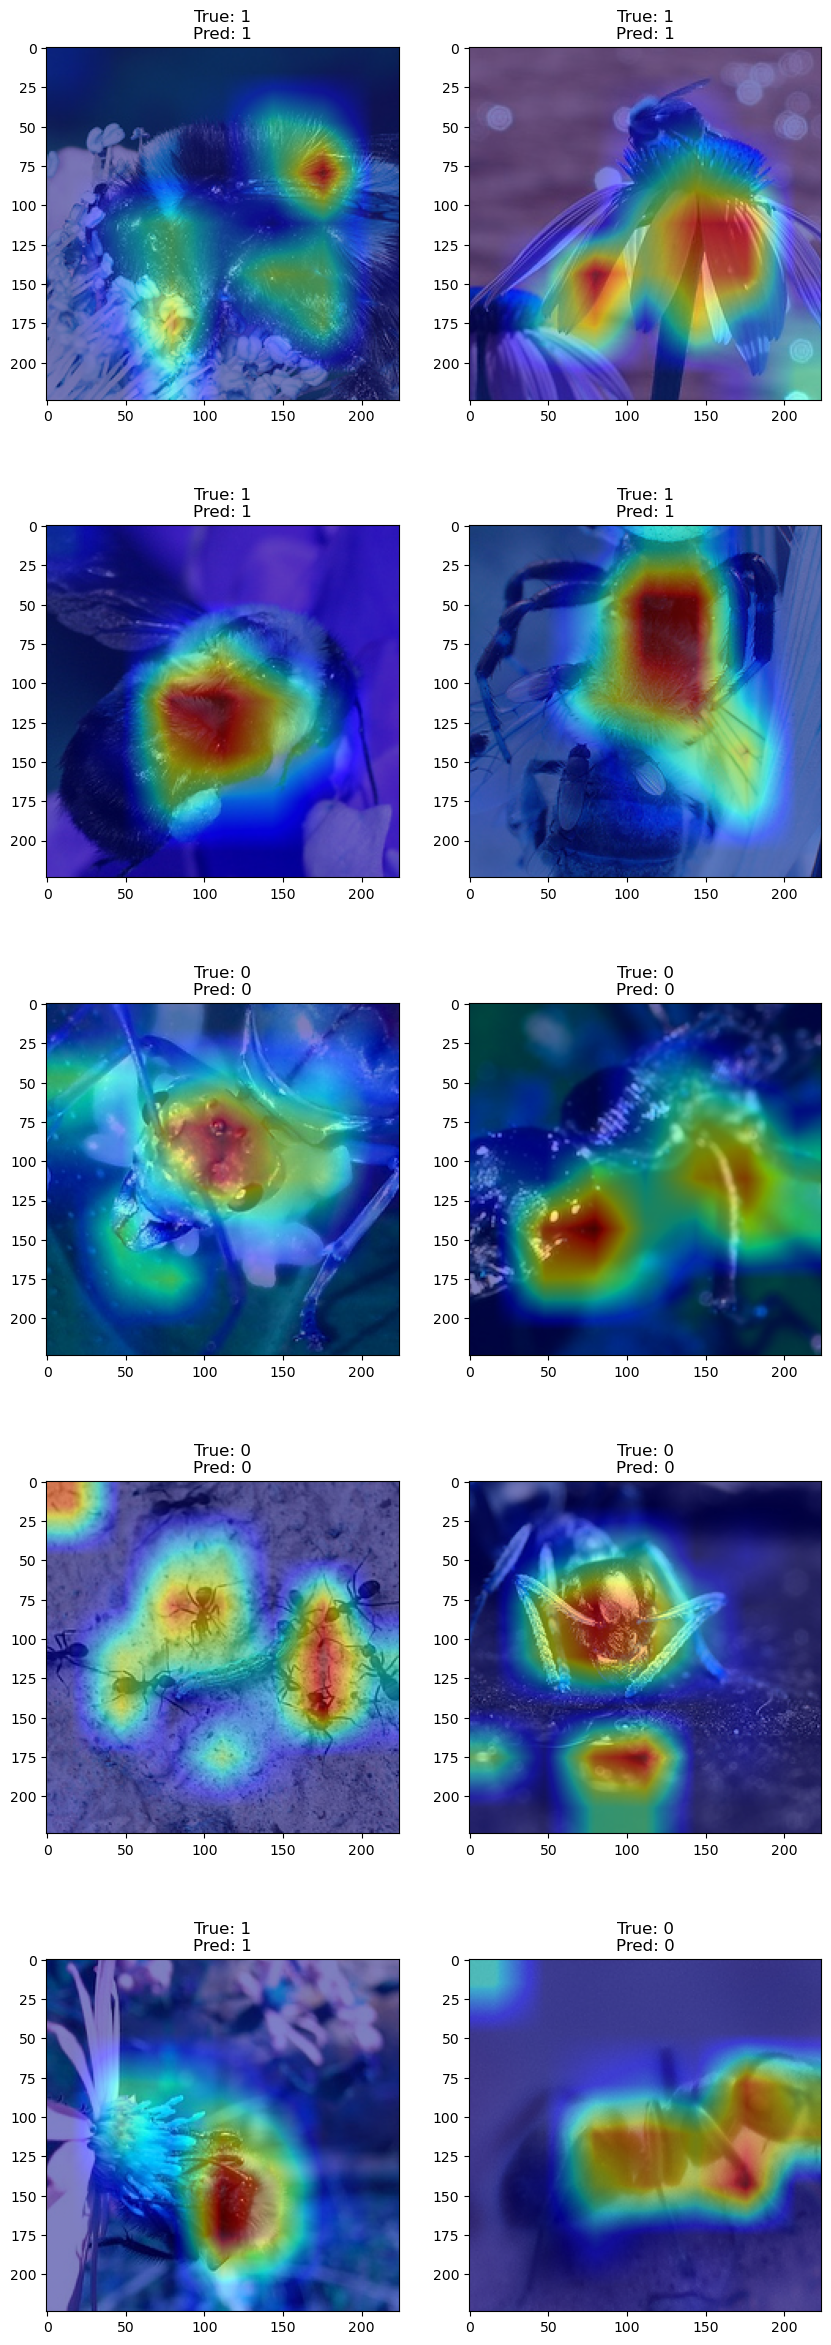

In [172]:
# モデルのロード
model = models.efficientnet_v2_s()
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)
checkpoint  = torch.load(weight_path)  # 重みのパスを指定
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Grad-CAM の対象レイヤーを指定
target_layer = model.features[-1]  # 最後の特徴層
cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)

# 画像の前処理
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 任意のフォルダに入った画像に適用
fig, ax = plt.subplots(5, 2, figsize=(10, 30))
for i, image_file in enumerate(image_files):
    image_path = os.path.join(image_folder, image_file)
    image_pil = Image.open(image_path).convert("RGB")
    input_tensor = transform(image_pil).unsqueeze(0)  # バッチ次元を追加
    
    # モデルに画像を通す
    outputs = model(input_tensor)
    pred_class = outputs.argmax(dim=1).item()
    
    # 正解ラベルをファイル名から取得
    true_label = image_file.split("_")[0]
    
    # Grad-CAM を適用
    activation_map = cam_extractor(pred_class, outputs)
    activation_map = activation_map[0].detach().cpu().numpy()           # (1, 7, 7)
    activation_map = np.transpose(activation_map, (1, 2, 0))            # (1, 7, 7) -> (7, 7, 1)
    activation_map = cv2.resize(activation_map, (224, 224))             # (7, 7, 1) -> (224, 224, 1)
    activation_map = utils.toHeatmap(activation_map)
    
    # 画像とオーバーレイ
    image_cv2 = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR) / 255.0
    image_cv2 = image_cv2[image_cv2.shape[0]//2-112:image_cv2.shape[0]//2+112, image_cv2.shape[1]//2-112:image_cv2.shape[1]//2+112, :]
    image_overlay = image_cv2 * 0.5 + activation_map * 0.5
    
    # 画像表示
    col = i % 2
    row = i // 2
    ax[row, col].imshow(image_overlay)
    ax[row, col].set_title(f"True: {true_label}\nPred: {pred_class}")
    #ax[row, col].axis("off")
plt.show()